In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Reshape, BatchNormalization
from tensorflow.keras.layers import AveragePooling1D, SeparableConv2D, Activation, concatenate, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
warnings.resetwarnings()

In [243]:

def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    # can't include the max date because need at least 1 day in future to predict. +1 because of how range doesn't include endpoint
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window) & 
                                (time_index > max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y




def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, date_normalization=True,
                          train_test_only=False):
    """ Split into training, validation and test data.
    """

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)
                   
    return splits


def minmax(X, X_min, X_max):
    # X_min and X_max need to have already been made into 4-d tensors with np.newaxis
    tile_shape = np.array(np.array(X.shape) / np.array(X_min.shape), dtype=int)
    denominator = np.tile(X_max, tile_shape) - np.tile(X_min, tile_shape)
    denominator[denominator==0] = 1
    X_scaled = (X - np.tile(X_min, tile_shape)) / denominator
    return X_scaled

def normal(X, X_mean, X_std):
    tile_shape = np.array(np.array(X.shape) / np.array(X_mean.shape), dtype=int)
    mean_ = np.tile(X_mean, tile_shape)
    std_ =  np.tile(X_std, tile_shape)   
    std_[np.where(std_==0.)] = 1
    X_scaled = ((X - mean_) /  std_)
    return X_scaled

def normalize_Xy_splits(splits, normalization_method='minmax', train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 1)
    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits

    if normalization_method=='minmax':
        # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
        # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
        # There is only a single value per feature in this case, meaning that to rescale, the values need to
        # be repeated for each validation, test frame for each country for each timestep.
        X_min = X_train.min(axis=(2))
        X_max = X_train.max(axis=(2))


        X_train_scaled = minmax(X_train, X_min[:, :, np.newaxis, :],
                        X_max[:, :, np.newaxis, :])
        X_test_scaled = minmax(X_test, X_min[-1][np.newaxis, :, np.newaxis, :], 
                               X_max[-1][np.newaxis, :, np.newaxis, :])
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = minmax(X_validate, X_min[-1,:][np.newaxis, :, np.newaxis, :], 
                                       X_max[-1,:][np.newaxis, :, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)
    else:
        
        X_mean = X_train.mean(axis=(1,2))
        X_std = X_train.std(axis=(1,2))


        X_train_scaled = normal(X_train, 
                                X_mean[:, np.newaxis, np.newaxis, :],
                                X_std[:, np.newaxis, np.newaxis, :])
        X_test_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
        
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

    return splits

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_test, y_naive, y_predict, title=''):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    ymax = np.max([np.log(1+y_test).max(), np.log(1+y_predict).max()])
    ax1.scatter(np.log(y_test+1), np.log(y_naive+1), s=5)
    ax1.plot([0, ymax], [0, ymax],color='r')

    ax2.scatter(np.log(y_test+1), np.log(y_predict+1), s=5)
    ax2.plot([0, ymax], [0, ymax],color='r')

    ax1.set_xlabel('Log(True value)')
    ax1.set_ylabel('Log(Predicted value)')
    ax1.set_title('Naive model')

    ax2.set_xlabel('Log(True value)')
    ax2.set_ylabel('Log(Predicted value)')
    ax2.set_title('CNN model')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('Log(True value)')
    ax.grid(True)
#     plt.show()
    return None

def residual_diff_plots(y_true, y_naive, y_predict, n_days_into_future, n_countries):
    
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_naive))
    ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
    ax2.plot(xrange, np.log(y_true+1)
             -np.log(y_predict+1))
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('Log(|True - Naive|)')
    ax2.set_ylabel('Log(|True - CNN|)')
    ax1.grid(True)
    ax2.grid(True)
    residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
    residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    plt.show()
    return None


# def Conv1D_model(X_train,f,k):
#     f1, f2 = f
#     k1, k2 = k

#     model = Sequential()
#     model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
#                      padding='valid',
#                      input_shape=X_train.shape[1:],
#                      activation='relu'
#                     )
#              )
#     model.add(Conv1D(filters=int(f2), 
#                      kernel_size=int(k2), 
#                      padding='valid',
#                      activation='relu'
#                     )
#              )

#     model.add(Flatten())
#     model.add(Dense(model.output.shape[1], 
#                     activation='relu'
#                    )
#              )
#     model.add(Dense(1, activation='relu'))
#     return model

should have been average/taking min max over countries as well as time. 

In [39]:
# Import cleaned data produced by other notebook. 
global_data = pd.read_csv('cnn_data.csv',index_col=0)

For the prototype, see what kind of result we get with just the data on the United States, and only use the new_cases_per_million feature.

In [40]:
data = global_data[global_data.location=='United States']

In [41]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data, 'log'))
data.loc[:, 'time_index'] += 1

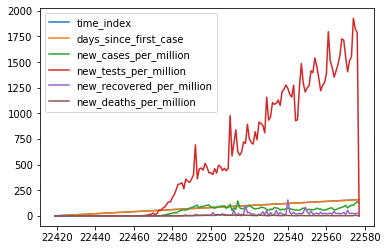

In [147]:
data.plot()

In [177]:
new_cases_index = column_search(data,'new_cases_per_million',threshold='match', return_style='iloc')[0]
# data = data[data.time_index>=40]
model_data = data.copy().iloc[:, 1:]
model_data =  model_data.apply(lambda x :np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_per_million',threshold='match', return_style='iloc')[0]

n_countries = data.location.nunique()
target_data = model_data.new_cases_per_million
# model_generator = Conv1D_model
time_index = data.time_index

frame_size = 28
start_date = 2*frame_size#+time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

# for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
#     # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#     frame_data = model_data[(time_index <= max_date_in_window) & 
#                             (time_index > max_date_in_window-frame_size)]
#     #     print(frame_data.shape)
#     # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#     reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#     #     print(reshaped_frame_data.shape)
#     # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#     # the first axis is always the default iteration axis. 
#     # *********************** WARNING: pad_sequences converts to integers by default *********************
#     resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#     frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
#     if max_date_in_window == start_date:
#         X = frame_data_4D.copy()
#     else:
#         X = np.concatenate((X, frame_data_4D),axis=0)

# y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
# y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]

# X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
# y_train =  y[:-(n_validation_frames+n_test_frames),:]
# X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
# y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# X_test = X[-n_test_frames:, :, :, :] 
# y_test = y[-n_test_frames:, :]
# splits =  (X_train, y_train, X_validate, y_validate,
#            X_test, y_test)

# y_train_time = y_time_index[:-(n_validation_frames+n_test_frames),:]
# y_validate = y_time_index[-(n_validation_frames+n_test_frames):-n_test_frames, :]
# y_test_time = y_time_index[-n_test_frames:, :]

In [209]:
for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index <= max_date_in_window) & 
                            (time_index > max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

        
y = target_data.values[-X.shape[0]:].reshape(-1,1)
y_time_index = time_index.values[-X.shape[0]:].reshape(-1,1)
# y = target_data.values.transpose()[-X.shape[0]:,:]
# y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:]
y_train =  y[:-(n_validation_frames+n_test_frames),:]
y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]


X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
y_train =  y[:-(n_validation_frames+n_test_frames),:]
X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_validate, y_validate,
           X_test, y_test)

y_train_time = y_time_index[:-(n_validation_frames+n_test_frames),:]
y_validate_time = y_time_index[-(n_validation_frames+n_test_frames):-n_test_frames, :]
y_test_time = y_time_index[-n_test_frames:, :]

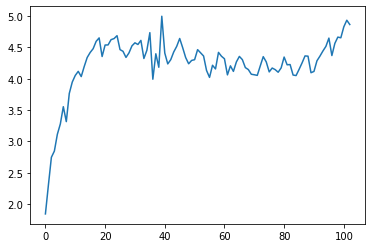

In [210]:
plt.plot(y)

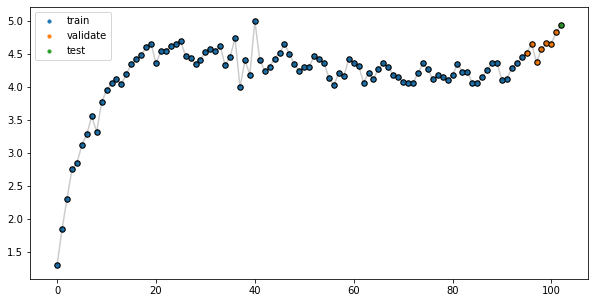

In [211]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,0,-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,0,-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,0,-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,0,-1,new_cases_index], s=10, label='test')
ax.plot(np.log(data.new_cases_per_million.values[start_date-1:-1]+1), color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

In [215]:
y_naive, y_predict, y_validate

(array([4.5147968 , 4.64627374, 4.36848536, 4.56260709, 4.66242915,
        4.65150018, 4.82600708]),
 array([4.6304674, 4.4148273, 4.1882505, 4.230255 , 4.2336025, 4.3892736,
        4.474981 ], dtype=float32),
 array([[4.64627374],
        [4.36848536],
        [4.56260709],
        [4.66242915],
        [4.65150018],
        [4.82600708],
        [4.93118075]]))

In [252]:
X_train = np.concatenate(X_train.reshape(-1, *X_train.shape[1:]), axis=0)
X_validate = np.concatenate(X_validate.reshape(-1, *X_validate.shape[1:]), axis=0)
X_test = np.concatenate(X_test.reshape(-1, *X_test.shape[1:]), axis=0)

epochs = 1000
batch_size = 8
learning_rate = 0.001
kernel = 4
N = 8
FC = 8

f1, f2 = 64, 8
k1, k2 = 
# model = Sequential()
# model.add(Conv1D(filters=int(N), kernel_size=int(kernel),
#                  padding='valid',
#                  input_shape=X_train.shape[1:],
#                  activation='relu'
#                 )
#          )

# model.add(Flatten())
# model.add(Dense(FC, 
#                 activation='relu'
#                )
#          )
# model.add(Dense(1, activation='relu'))


f1, f2 = f
k1, k2 = k

model = Sequential()
model.add(Conv1D(filters=int(f1), kernel_size=int(k1),
                 padding='valid',
                 input_shape=X_train.shape[1:],
                 activation='relu'
                )
         )
model.add(Conv1D(filters=int(f2), 
                 kernel_size=int(k2), 
                 padding='valid',
                 activation='relu'
                )
         )

model.add(Flatten())
model.add(Dense(model.output.shape[1], 
                activation='relu'
               )
         )
model.add(Dense(1, activation='relu'))


model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))


history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_validate, y_validate), 
          batch_size=batch_size, verbose=0)

_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

NameError: name 'f' is not defined

In [232]:
y_naive.shape

(7,)

In [233]:
y_true.shape

(7,)

In [234]:
y_predict.shape

(7,)

In [236]:
n_countries

1

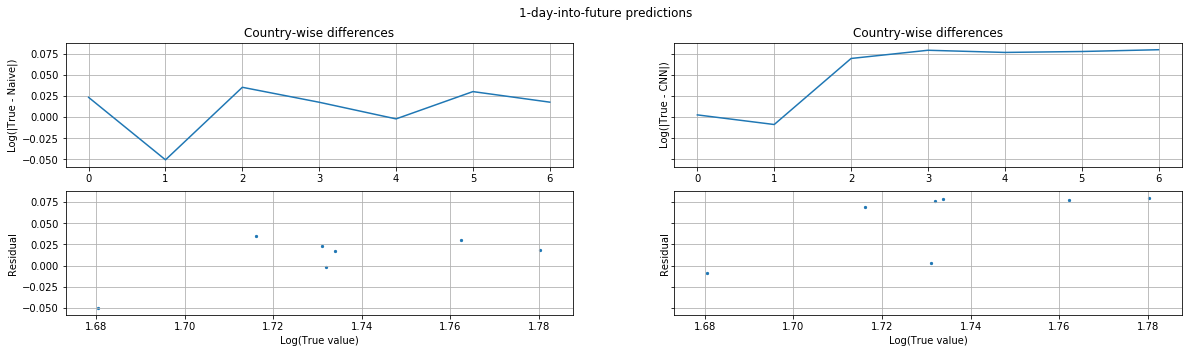

In [239]:
fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
xrange = range(len(y_naive))
ax1.plot(xrange, np.log(y_true+1)
         -np.log(y_naive+1))
ax2.plot(xrange, np.log(y_true+1)
         -np.log(y_predict+1))
fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
ax1.set_title('Country-wise differences')
ax2.set_title('Country-wise differences')
ax1.set_ylabel('Log(|True - Naive|)')
ax2.set_ylabel('Log(|True - CNN|)')
ax1.grid(True)
ax2.grid(True)
residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
plt.show()

In [249]:
y_true = y_validate.ravel()
y_naive = X[-n_validation_frames-n_test_frames:-n_test_frames, 0, -1, new_cases_index]
y_predict = model.predict(X_validate).ravel()

In [250]:
mae_naive = mean_squared_error(y_validate, y_naive)
mae_predict = mean_squared_error(y_validate, y_predict)
r2_naive = explained_variance_score(y_validate, y_naive)
r2_predict = explained_variance_score(y_validate, y_predict)

print('{}-step MSE [Naive, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

1-step MSE [Naive, CNN] = [0.026247693753966496,0.12897250632268054]
1-step R^2 [Naive, CNN] = [0.1877649045917139,-0.43416901296796206]


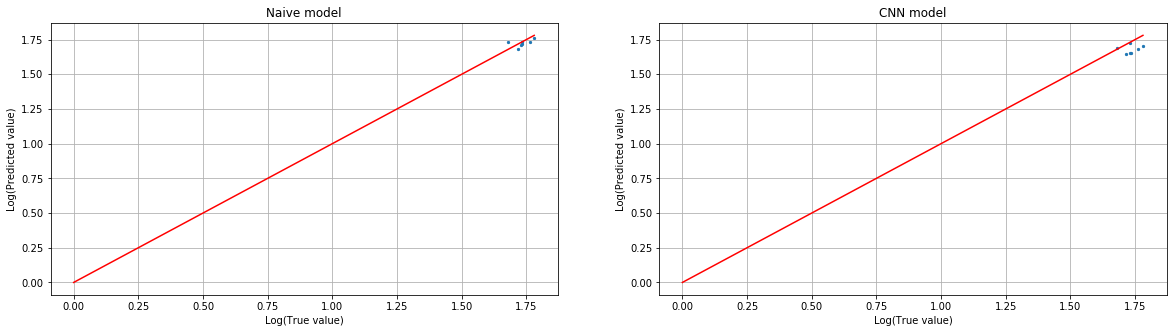

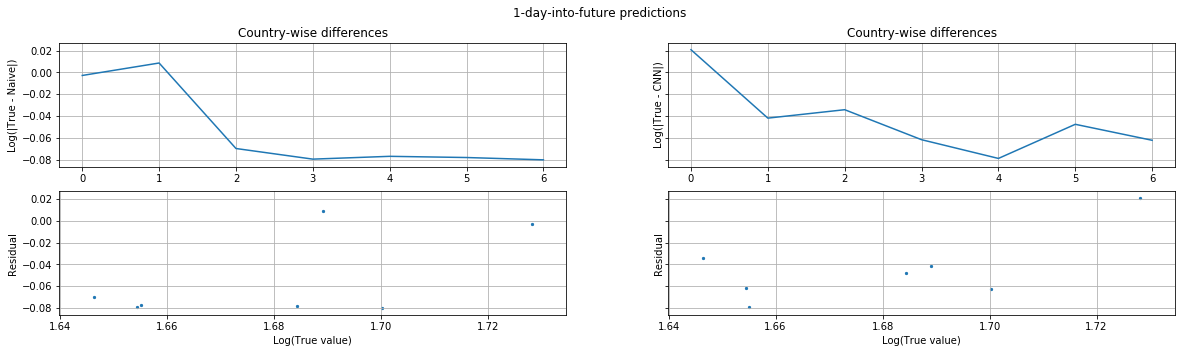

In [251]:
true_predict_plot(y_validate, y_naive, y_predict, title='')
residual_diff_plots(y_validate.ravel(),y_naive, y_predict, n_days_into_future, n_countries)

In [51]:
for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 1):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index <= max_date_in_window) & 
                            (time_index > max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]

X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
y_train =  y[:-(n_validation_frames+n_test_frames),:]
X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_validate, y_validate,
           X_test, y_test)

y_train_time = y_time_index[:-(n_validation_frames+n_test_frames),:]
y_validate = y_time_index[-(n_validation_frames+n_test_frames):-n_test_frames, :]
y_test_time = y_time_index[-n_test_frames:, :]


for i in range(1, X_train.shape[0]+1):
    # find the minima and maxima of all features for all countries, ranging up to current frame and 
    # each time step in the frame. 
    up_to_current_frame_min = X_train[:i,:,:,:].min((0,1,2))
    up_to_current_frame_max = X_train[:i,:,:,:].max((0,1,2))
    latest_min_array = np.tile(up_to_current_frame_min[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
    latest_max_array = np.tile(up_to_current_frame_max[np.newaxis, np.newaxis, np.newaxis, :],(1,1,frame_size,1))
    if i == 1:
        frame_min_array = latest_min_array
        frame_max_array = latest_max_array
    else:

        frame_min_array = np.concatenate((frame_min_array, 
                                               latest_min_array)
                                              ,axis=0)
        frame_max_array = np.concatenate((frame_max_array, 
                                               latest_max_array)
                                              ,axis=0)
        
frame_minmax_denominator = (frame_max_array-frame_min_array)
num_zeros_train = (frame_minmax_denominator==0).sum()

frame_minmax_denominator[np.where(frame_minmax_denominator==0)]=1
X_train = 0.5*(X_train - frame_min_array) / frame_minmax_denominator
# Use the latest min and max for test scaling.

frame_denom_for_test = latest_max_array - latest_min_array
num_zeros_test = (frame_denom_for_test==0).sum()

frame_denom_for_test[np.where(frame_denom_for_test==0)] = 1

X_validate = 0.5*(X_validate - latest_min_array) / frame_denom_for_test
X_test = 0.5*(X_test - latest_min_array) / frame_denom_for_test


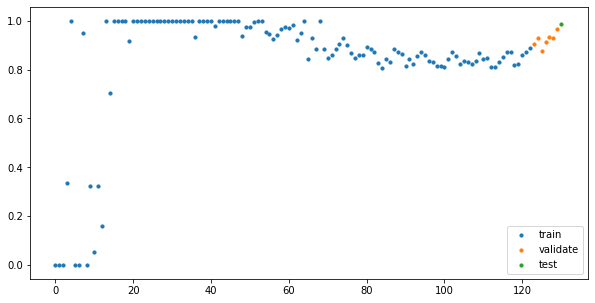

In [62]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X_train)), X_train[:,0,-1,:], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,0,-1,:], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,0,-1,:], s=10, label='test')
# -1 because the last day's value is contained in y, not X.
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

Scatter plots of train, validate, test sets, by plotting all values in black first I can ensure that the points
are correctly ordered and at the correct values because it makes the rest of the points look like they have black borders.
The "missing" data point at the end is because it is in the prediction variable y, and not in X.

At first the following plot looks wrong because y looks like it is 1-day behind but this is only because I am
not providing the time values. I.e. the 5th value of y is actually the 6th value of X. 

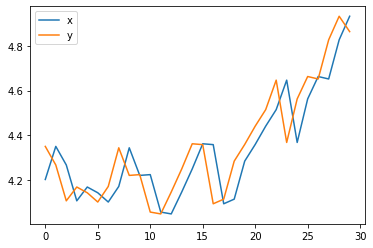

In [68]:
plt.plot(X[-30:,0,-1,:], label='x')
plt.plot(y[-30:], label='y')
plt.legend()
plt.show()

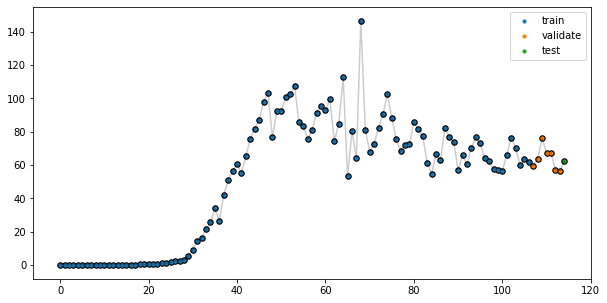

In [223]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_train)), X_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_train), len(X_train)+len(X_validate)), X_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_train)+len(X_validate), len(X)), X_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
ax.plot(data[data.location=='United States'].new_cases_per_million.values[frame_size-1:-1], color='k',alpha=0.2)
plt.legend()
_ = plt.show()
# plt.plot(X_validate[:,0,-1,:])

In [213]:
rdata = pd.read_csv('regression_data.csv', index_col=0)

In [214]:
rdata

,location,date,time_index,days_since_first_case,log_new_cases_per_million,log_new_tests_per_million,log_new_recovered_per_million,log_new_deaths_per_million,new_cases_per_million,new_tests_per_million,...,e3_fiscal_measures_rolling_mean_28,e4_international_support_rolling_mean_28,economic_support_index_rolling_mean_28,government_response_index_rolling_mean_28,h1_public_information_campaigns_rolling_mean_28,h2_testing_policy_rolling_mean_28,h3_contact_tracing_rolling_mean_28,h4_emergency_investment_in_healthcare_rolling_mean_28,h5_investment_in_vaccines_rolling_mean_28,stringency_index_rolling_mean_28
0,Afghanistan,2020-01-22,0,0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
1,Afghanistan,2020-01-23,1,0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
2,Afghanistan,2020-01-24,2,0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
3,Afghanistan,2020-01-25,3,0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
4,Afghanistan,2020-01-26,4,0,0.000000,0.000000,0.000000,0.0,0.000,0.000000,...,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,Zimbabwe,2020-06-24,154,96,0.628609,3.410073,1.603341,0.0,0.875,29.267452,...,0.0,0.0,25.0,62.450,2.0,1.0,1.0,0.0,0.0,75.395714
23687,Zimbabwe,2020-06-25,155,97,0.289680,3.925013,0.289985,0.0,0.336,49.653746,...,0.0,0.0,25.0,62.015,2.0,1.0,1.0,0.0,0.0,74.767500
23688,Zimbabwe,2020-06-26,156,98,0.880871,0.000000,0.385922,0.0,1.413,0.000000,...,0.0,0.0,25.0,61.580,2.0,1.0,1.0,0.0,0.0,74.139286
23689,Zimbabwe,2020-06-27,157,99,0.514618,3.707784,0.385922,0.0,0.673,39.763366,...,0.0,0.0,25.0,61.145,2.0,1.0,1.0,0.0,0.0,73.511071


In [ ]:
n_prune = 2
mae_list_naive = []
r2_list_naive = []
mae_list_predict = []
r2_list_predict = []
# data = data[data.time_index >= first_day]
model_data = data.iloc[:, n_prune:].copy()#.apply(lambda x : np.log(x+1))
new_cases_index = column_search(model_data,'new_cases_weighted',threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_weighted
time_index = data.time_index
frame_size = 14
start_date = frame_size + time_index.min()
# start_date = 50
n_validation_frames = 0
n_test_frames = 1
n_days_into_future = 1
train_or_test = 'train'

for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
    # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
    frame_data = model_data[(time_index < max_date_in_window) & 
                            (time_index >= max_date_in_window-frame_size)]
    #     print(frame_data.shape)
    # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
    reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
    #     print(reshaped_frame_data.shape)
    # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
    # the first axis is always the default iteration axis. 
    # *********************** WARNING: pad_sequences converts to integers by default *********************
    resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
    frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
    if max_date_in_window == start_date:
        X = frame_data_4D.copy()
    else:
        X = np.concatenate((X, frame_data_4D),axis=0)

y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
y_time_index = time_index.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]

X_train= X[:-n_test_frames,:,:,:]
y_train =  y[:-n_test_frames,:]
X_test = X[-n_test_frames:, :, :, :] 
y_test = y[-n_test_frames:, :]
splits =  (X_train, y_train, X_test, y_test)
y_train_time = y_time_index[:-n_test_frames,:]
y_test_time = y_time_index[-n_test_frames:, :]


X_train_model = np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
X_test_model = np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
y_train_model = y_train.ravel()
y_test_model = y_test.ravel()


model = Ridge(alpha=0.01, fit_intercept=False, max_iter=5000) 

_ = model.fit(X_train_model, y_train_model.ravel())

if train_or_test == 'train':
    y_true = y_train_model
    y_naive = X_train[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_train_model, 
                                                 y_train_model.ravel(), 
                                                 plot=False, metric='mae')
else:
    y_true = y_test
    y_naive = X_test[:, :, -1, new_cases_index].ravel()
    _, y_predict, mae = classifier_analysis(model, X_test_model,
                                                 y_test.ravel(),
                                                 plot=False, metric='mae')
    

print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
y_predict[y_predict<0]=0


mae_train_naive = mean_absolute_error(y_true.ravel(), y_naive.ravel())
mae_predict = mean_absolute_error(y_true.ravel(), y_predict)
r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
r2_predict = explained_variance_score(y_true.ravel(), y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_train_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_train_naive, r2_predict))

true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict)
residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, data.location.nunique())